# Sensitive Data Classification Using Deep Learning

# Importing libraries and downloading the dataset

In [2]:
# Importing the necessary libraries
import tensorflow as tf
import numpy as np
import os

# Downloading the dataset
git_folder = "/content/sensitive_data_classification"
if os.path.exists(git_folder) == False:
  !git clone https://github.com/Mrnidhi/sensitive_data_classification.git

training_folder = git_folder + "/dataset/training"
validation_folder = git_folder + "/dataset/validation"

Cloning into 'sensitive_data_classification'...
remote: Enumerating objects: 720, done.
remote: Counting objects: 100% (720/720), done.
remote: Compressing objects: 100% (718/718), done.
remote: Total 720 (delta 2), reused 720 (delta 2), pack-reused 0
Receiving objects: 100% (720/720), 81.53 MiB | 45.05 MiB/s, done.
Resolving deltas: 100% (2/2), done.


## Sample Data

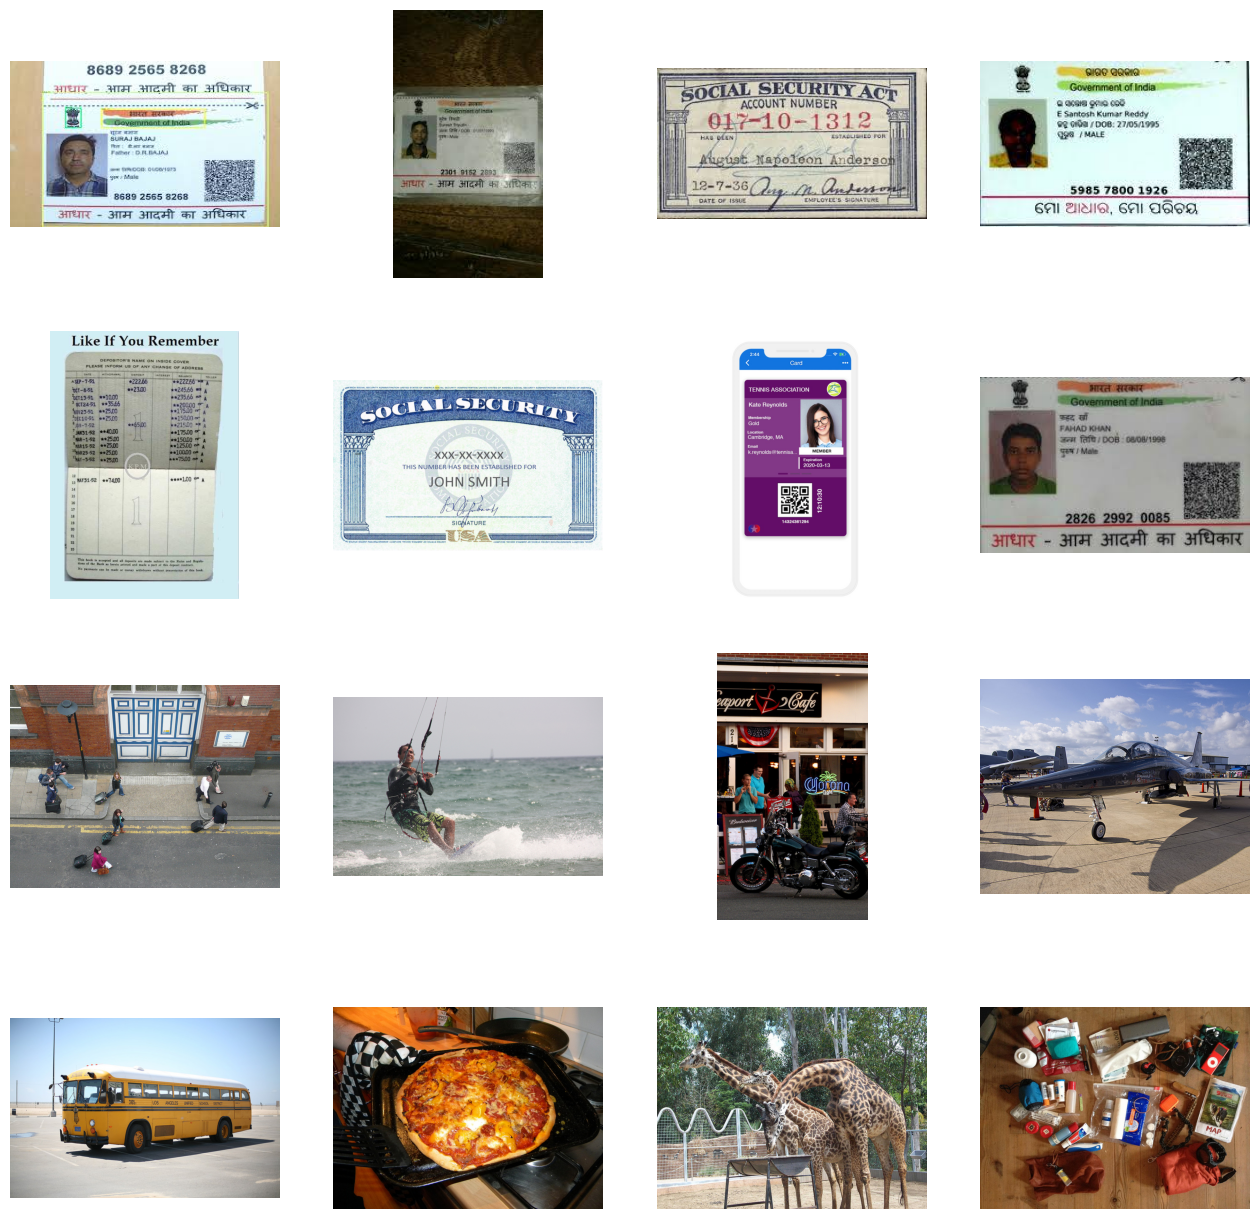

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

train_sensitive_dir = os.path.join(training_folder+"/sensitive")
train_nonsensitive_dir = os.path.join(training_folder+"/nonsensitive")
train_sensitive_names = os.listdir(train_sensitive_dir)
train_nonsensitive_names = os.listdir(train_nonsensitive_dir)

pic_index += 8
next_sensitive_pix = [os.path.join(train_sensitive_dir, fname)
                for fname in train_sensitive_names[pic_index-8:pic_index]]
next_nonsensitive_pix = [os.path.join(train_nonsensitive_dir, fname)
                for fname in train_nonsensitive_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_sensitive_pix+next_nonsensitive_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Model

In [4]:
# Callbacks to cancel training after reaching a desired accuracy
# This is done to avoid overfitting
DESIRED_ACCURACY = 0.98

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > DESIRED_ACCURACY:
      print("Reached 98% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

# Sequential - defines a SEQUENCE of layers in the neural network.
model = tf.keras.models.Sequential([
  # 2D Convolution Layer - Filter, Kernel_size, activation fn
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
  # Max pooling operation for 2D data - Pool size
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  # Flattens the input. Does not affect the batch size.
  tf.keras.layers.Flatten(),
  # Regular densely-connected Neural Network layer with ReLU activation function.
  tf.keras.layers.Dense(512, activation='relu'),
  # Regular densely-connected Neural Network layer with sigmoid activation function.
  tf.keras.layers.Dense(1, activation='sigmoid')
])

from tensorflow.keras.optimizers import RMSprop

# model.compile - Configures the model for training.
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# Adam -  optimization algorithm used instead of the classical stochastic gradient descent procedure to update network weights.

# Display the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

## Preprocessing, Data Augmentation & Training

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescaling - 1/255 is to transform every pixel value from range [0,255] -> [0,1]
# Performing image augmentation for training data
train_datagen = ImageDataGenerator(rescale=1/255,
                                  rotation_range=20,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1/255)

# flow_from_directory - Takes the path to a directory & generates batches of data.
train_generator = train_datagen.flow_from_directory(
        training_folder,
        target_size=(150, 150),
        batch_size=30,
        class_mode='binary',
        shuffle=True
       )

validation_generator = validation_datagen.flow_from_directory(
        validation_folder,
        target_size=(150, 150),
        batch_size=5,
        class_mode='binary',
        shuffle=True
        )

num_epochs = 500
# model.fit - Train the model for a fixed number of epochs
history = model.fit(
      train_generator,
      steps_per_epoch=10,
      epochs=num_epochs,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8,
      callbacks=[callbacks])

Found 600 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/500
10/10 [==============================] - 10s 356ms/step - loss: 0.7533 - accuracy: 0.5633 - val_loss: 0.5577 - val_accuracy: 0.8000
Epoch 2/500
10/10 [==============================] - 3s 277ms/step - loss: 0.5722 - accuracy: 0.7433 - val_loss: 0.2891 - val_accuracy: 0.9250
Epoch 3/500
10/10 [==============================] - 3s 292ms/step - loss: 0.5029 - accuracy: 0.7767 - val_loss: 0.2420 - val_accuracy: 0.9500
Epoch 4/500
10/10 [==============================] - 3s 291ms/step - loss: 0.5332 - accuracy: 0.7533 - val_loss: 0.3673 - val_accuracy: 0.8500
Epoch 5/500
10/10 [==============================] - 3s 291ms/step - loss: 0.4662 - accuracy: 0.7900 - val_loss: 0.1971 - val_accuracy: 0.9500
Epoch 6/500
10/10 [==============================] - 4s 406ms/step - loss: 0.5254 - accuracy: 0.7433 - val_loss: 0.3419 - val_accuracy: 0.9500
Epoch 7/500
10/10 [==============================] - 3s 292

## Plotting Accuracy and Loss Functions

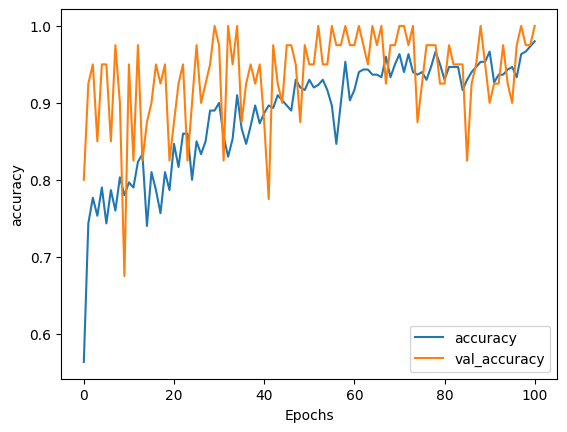

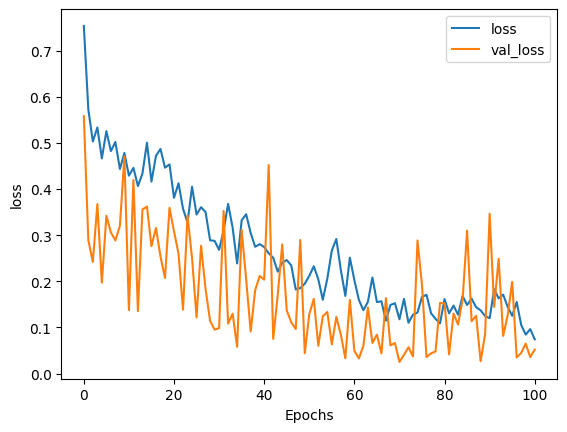

In [6]:
import matplotlib.pyplot as plt

# Plot the accuracy and loss functions
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Confusion Matrix

20/20 [==============================] - 1s 52ms/step
Confusion Matrix
Accuracy for 25 Test Data =  60.0
Accuracy for 50 Test Data =  53.06122448979592
Accuracy for 75 Test Data =  53.333333333333336
Accuracy for 100 Test Data =  51.515151515151516


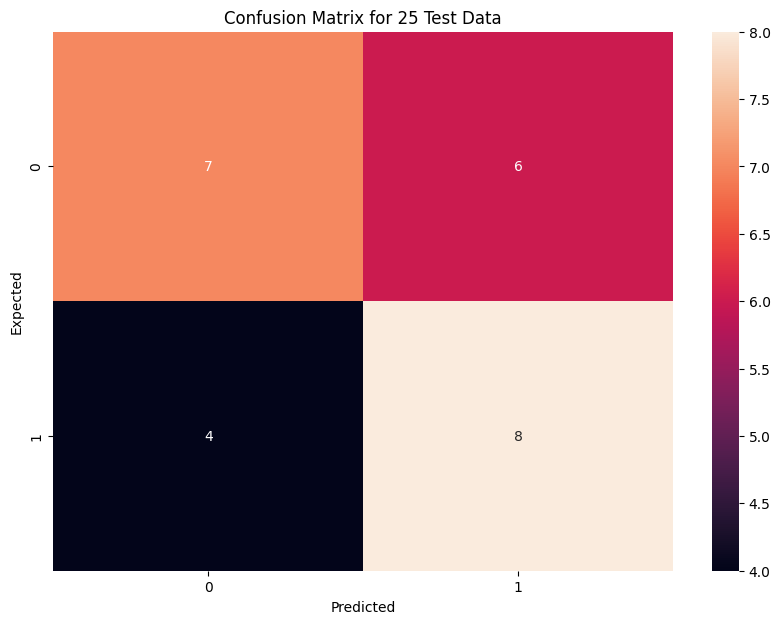

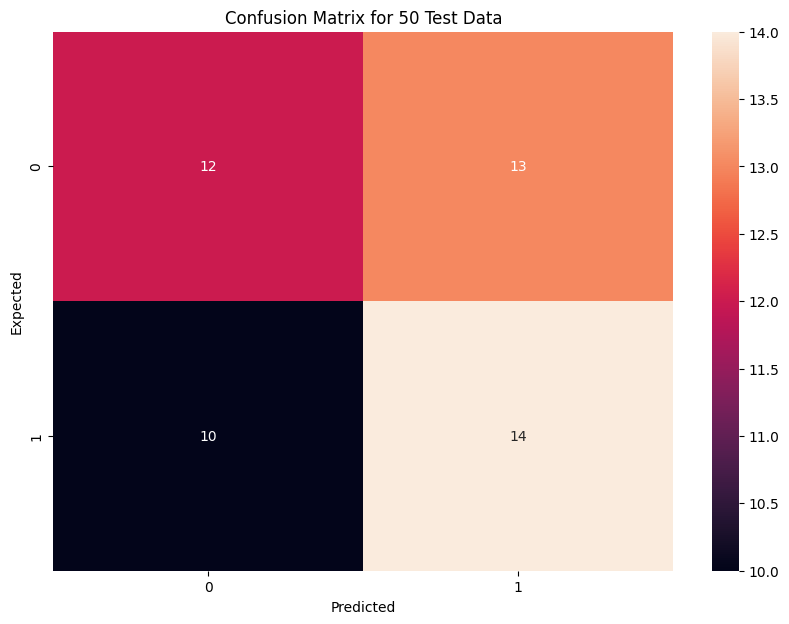

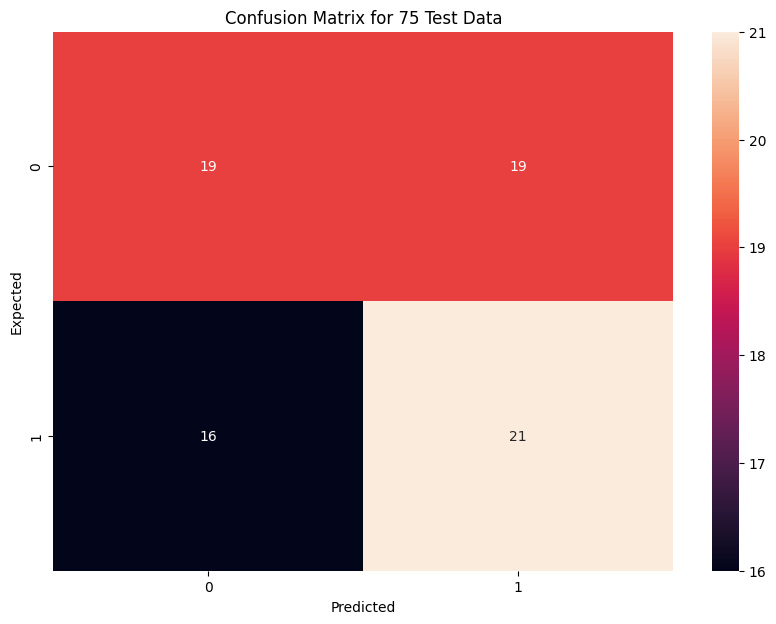

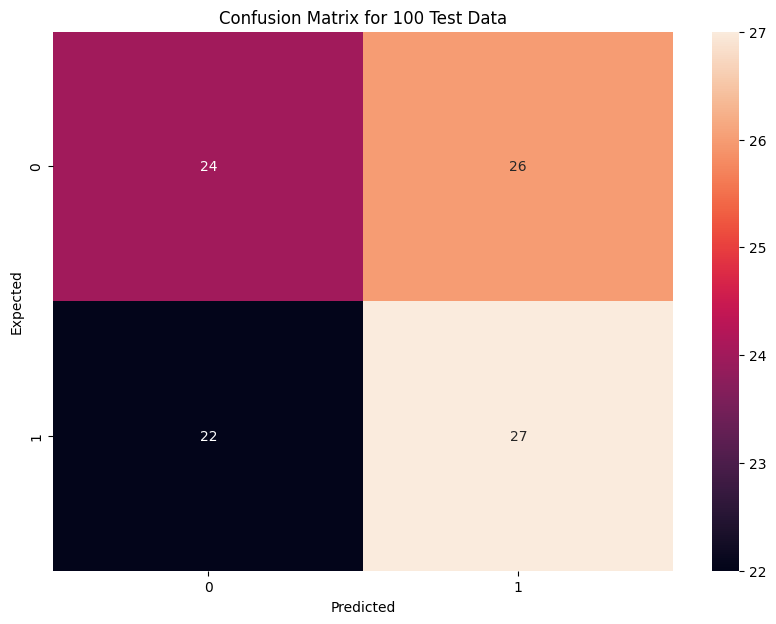

In [7]:
import seaborn
y_pred = model.predict(validation_generator, 20)
print('Confusion Matrix')
y_predicted_labels = y_pred > 0.5

size = np.size(y_predicted_labels)
y_predicted_labels = y_predicted_labels.reshape(size, )

for i in range (1, 5):
  total = i * size // 4
  mid = 49
  start = mid-((total+1)//2)+1
  end = mid+((total+1)//2)
  cm = tf.math.confusion_matrix(labels=validation_generator.labels[start:end],predictions=y_predicted_labels[start:end])

  # Calculate accuracy
  cm_np = cm.numpy()
  conf_acc = (cm_np[0, 0] + cm_np[1, 1])/ np.sum(cm_np) * 100
  print("Accuracy for", str(total), "Test Data = ", conf_acc)

  # Plot the confusion matrix
  plt.figure(figsize = (10,7))
  seaborn.heatmap(cm, annot=True, fmt='d')
  plt.title("Confusion Matrix for " + str(total) + " Test Data")
  plt.xlabel('Predicted')
  plt.ylabel('Expected')

## Sample Example

Saving 1 (25).jpg to 1 (25) (1).jpg
Saving 1 (26).jpg to 1 (26).jpg
Saving 1 (27).jpg to 1 (27).jpg
Saving 1 (29).jpg to 1 (29).jpg
Saving 1 (30).jpg to 1 (30).jpg
Saving 1 (31).JPG to 1 (31).JPG
Saving 1 (32).jpg to 1 (32).jpg
Saving 1 (33).jpg to 1 (33).jpg
1/1 [==============================] - 0s 18ms/step
[1.]
1 (25) (1).jpg - Sensitive
1/1 [==============================] - 0s 19ms/step
[1.]
1 (26).jpg - Sensitive
1/1 [==============================] - 0s 23ms/step
[1.]
1 (27).jpg - Sensitive
1/1 [==============================] - 0s 19ms/step
[0.]
1 (29).jpg - Non-sensitive
1/1 [==============================] - 0s 19ms/step
[2.546597e-36]
1 (30).jpg - Non-sensitive
1/1 [==============================] - 0s 22ms/step
[0.]
1 (31).JPG - Non-sensitive
1/1 [==============================] - 0s 18ms/step
[1.]
1 (32).jpg - Sensitive
1/1 [==============================] - 0s 21ms/step
[1.]
1 (33).jpg - Sensitive


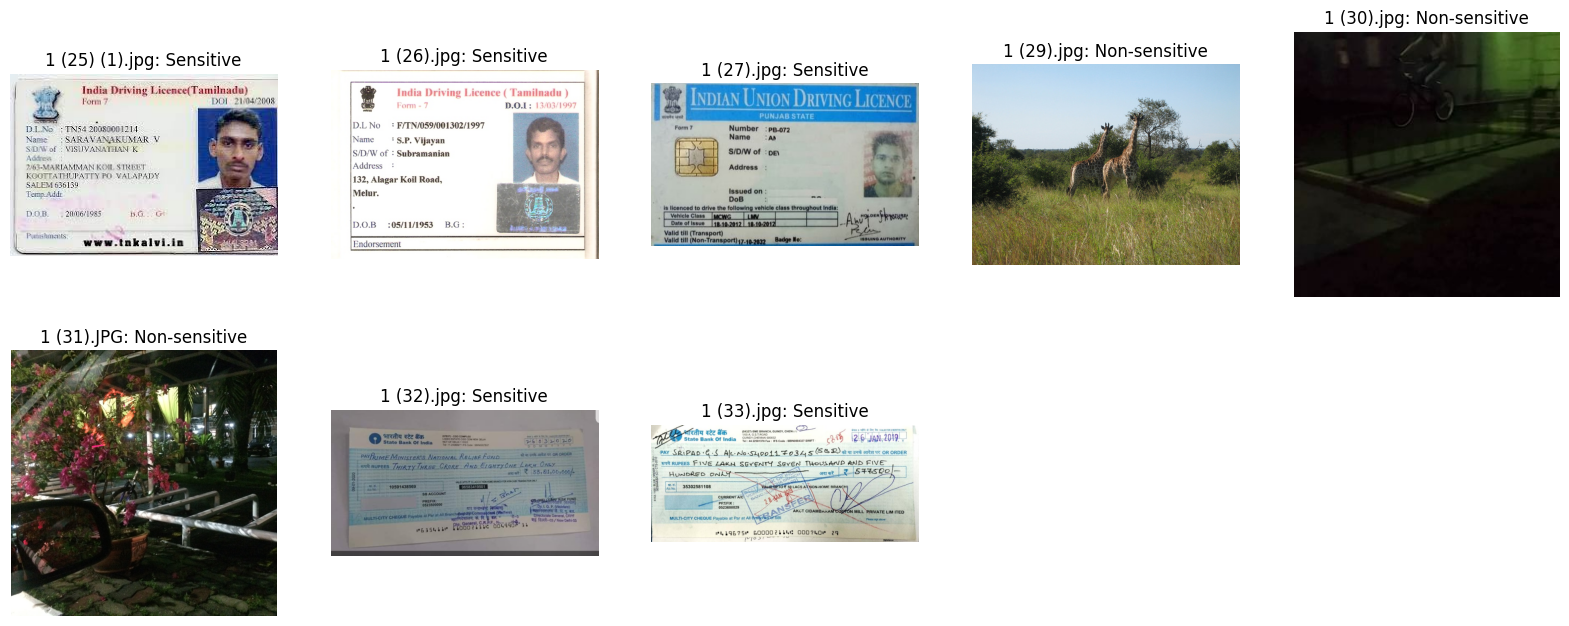

In [9]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
result = dict()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " - Sensitive")
    result[fn] = "Sensitive"
  else:
    print(fn + " - Non-sensitive")
    result[fn] = "Non-sensitive"

plt.figure(figsize=(20,20))

for i, fn in enumerate(uploaded.keys()):
  image = plt.imread(fn)
  plt.subplot(5, 5, i+1)
  plt.axis("off")
  plt.imshow(image)
  ans = fn + ": " + result[fn]
  plt.title(ans)